# Кейс Минздрава.Cпасение жизней с помощью ИИ
Постановка задачи:
Создание моделей машинного обучения для прогнозирования риска летального
исхода у пациентов, находящихся на стационарном лечении на основании данных первичного
осмотра.

На основании предоставленных данных, содержащих анонимизированные данные МИС ФГБУ
«НМИЦ им. В. А. Алмазова» Минздрава России за 2019 г, необходимо разработать модель
машинного обучения для прогнозирования риска летального исхода у пациентов,
находящихся на стационарном лечении и выявления факторов, коррелирующих с целевым
признаком.

Эффективная модель машинного обучения, направленная на выявление и стратификацию
рисков, позволила бы индивидуально подходить к оценке рисков у больных и, таким образом,
и, возможно, предупредить их возникновение.

## Комментарий к выполнению кода

В данном проекте используются результаты предобработки выполненные коллегами по команде, по причине ограниченного тайминга, свести все в один файл не удалось и поэтому часть предобработки данных не получится полностью воспроизвести в данном ноутбуке, но процесс обучения моделей, при указании путей к нужным файлам будет выполнен без ошибок.

Ссылка на файлы используемые в данном проекте прилагается: 

https://drive.google.com/drive/folders/1ev3YhBtjxXqcmSEgRzWiFDu1GWl2IIM7?usp=sharing

In [2220]:
# импорт необходимых библиотек

import re
import time

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import joblib
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

## Загрузка данных

In [2]:
# укажем путь к основной директории с данными
path_main_dir = r"C:\Users\IvanovNikita\OneDrive - ООО «АЛЬМА Сервисез Компани»\Рабочий стол\rosminzdrav-dataset"

In [853]:
# Загрузим таблицу с данными
train_data = pd.read_csv(path_main_dir+'\\train.csv')

In [854]:
train_data

,id,text,label
0,0,"Температура тела : 36,5 С\nВеc, кг : 74 ,\nРос...",0.0
1,1,Педикулез : отр\nЧесотка : отр\nИБС СН 2фк\nДа...,0.0
2,2,"Температура тела : 36,4 С\nВеc, кг : 73 ,\nРос...",0.0
3,3,"Температура тела : 36,4 С\nВеc, кг : 92\nРост,...",0.0
4,4,Педикулез : отр\nЧесотка : отр\nФлюорограмма Н...,0.0
...,...,...,...
79331,79335,Множественная миома матки.\nДата поступления в...,0.0
79332,79336,"Температура тела : 36,5 С\nВеc, кг : 85 ,\nРос...",0.0
79333,79337,Дата начала действия : 01.11.2016\nВид поступл...,0.0
79334,79338,"Код по МКБ10 : G44.1 Сосудистая головная боль,...",0.0


In [ ]:
# Загрузим результаты парсинга коллег по команде
parse_data = pd.read_csv(path_main_dir +"\\alex_parse\\df_pr.csv")

In [917]:
parse_data

,id,sex,weight,height,puls,ad_s,ad_d,diabet2,sam_prishel,ekg_PQ,ekg_QRS,ekg_QT,dmarkers,bmi
0,0,NaN,74,176,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,0.0,23.8894628099174
1,1,1.0,NaN,NaN,68.0,130.0,90.0,0,1.0,NaN,NaN,NaN,0.0,NaN
2,2,1.0,73,174,58.0,125.0,80.0,0,1.0,NaN,NaN,NaN,0.0,24.1115074646585
3,3,NaN,92,165,NaN,NaN,NaN,0,1.0,252.0,108.0,446.0,0.0,33.7924701561065
4,4,0.0,NaN,NaN,70.0,110.0,80.0,0,1.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79330,79335,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,0.0,NaN
79331,79336,1.0,85,164,78.0,110.0,80.0,0,1.0,NaN,NaN,NaN,0.0,31.6032123735872
79332,79337,1.0,NaN,NaN,68.0,120.0,80.0,0,1.0,NaN,NaN,NaN,0.0,NaN
79333,79338,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,0.0,NaN


In [921]:
# Сохраним копию исходного файла
source_train = train_data.copy()

In [922]:
# Объединим результаты парсинга
train_data = train_data.join(parse_data, rsuffix=' parse')

In [924]:
# Получим количество заполненных полей каждого пациента
n_columns = {}
errors_rows = []
for row in train_data.index:
    try:
        n_columns[row] = (len(train_data.iloc[row, 1].split('\n')))
    except:
        errors_rows.append(row)
        n_columns[row] = np.nan

In [927]:
# Добавим в качестве признака
train_data['n_fields'] = pd.Series(n_columns)

In [32]:
train_data[['n_fields', 'label']].corr()

,n_fields,label
n_fields,1.000000,0.027435
label,0.027435,1.000000


In [36]:
# Выведем распределение по целевому признаку
label_0 = train_data[train_data['label'] == 0]
label_1 = train_data[train_data['label'] == 1]

display(label_0.shape[0])
display(label_1.shape[0])

78829

503

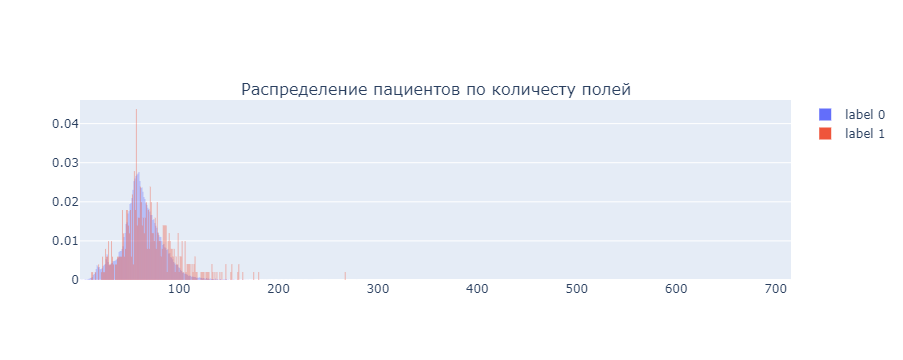

In [2632]:
fig = make_subplots(1,1,
                    subplot_titles=['Распределение пациентов по количесту полей']
                   )

fig.add_trace(go.Histogram(x = np.array(label_0['n_fields']), name = 'label 0', histnorm = 'probability'))

fig.add_trace(go.Histogram(x = np.array(label_1['n_fields']), name = 'label 1', histnorm = 'probability'))

fig.write_html(path_main_dir+'\\fields_distributions.html')

fig.show()

## Парсинг возраста

In [928]:
# Сохраним строки содержащие текст дата и время рождения
birdth = train_data[train_data.iloc[:,1].str.contains('Дата и время рождения')]

In [931]:
# Спарсим возраст с указанием слова год
start = time.time()
age_string = {}
errors = []
for i in train_data.index:
    try:
        patient_data = [x.split(':') for x in train_data.iloc[i, 1].split('\n')]
    except:
        age_string[i] = 'fail'
    results = []
    for field in patient_data:
        for string in field:
            result = re.findall(r'^\w*ациент\w{0,2}.{0,3}(\d{2}).*год', string)
            if len(result) != 0:
                results.append(result)
    if len(results) > 0:
        age_string[i] = results[0][0]
    else:
        age_string[i] = np.nan
print('Время обработки составило: ',int(time.time() - start), 'сек.')

Время обработки составило:  19 сек.


In [932]:
# Спарсим возраст с указанием слова лет
start = time.time()
age_string_1 = {}
errors = []
for i in train_data.index:
    try:
        patient_data = [x.split(':') for x in train_data.iloc[i, 1].split('\n')]
    except:
        age_string[i] = 'fail'
    results = []
    for field in patient_data:
        for string in field:
            result = re.findall(r'^\w*ациент\w{0,2}.{0,3}(\d{2}).*лет', string)
            if len(result) != 0:
                results.append(result)
    if len(results) > 0:
        age_string_1[i] = results[0][0]
    else:
        age_string_1[i] = np.nan
print('Время обработки составило: ',int(time.time() - start), 'сек.')

Время обработки составило:  17 сек.


In [933]:
# Спарсим возраст детей до года
start = time.time()
age_string_2 = {}
errors = []
for i in train_data.index:
    try:
        patient_data = [x.split(':') for x in train_data.iloc[i, 1].split('\n')]
    except:
        age_string[i] = 'fail'
    results = []
    for field in patient_data:
        for string in field:
            result = re.findall(r'Ребенок до.{0,3}(\d).*года', string)
            if len(result) != 0:
                results.append(result)
    if len(results) > 0:
        age_string_2[i] = results[0][0]
    else:
        age_string_2[i] = np.nan
print('Время обработки составило: ',int(time.time() - start), 'сек.')

Время обработки составило:  13 сек.


In [934]:
age_parsing = pd.DataFrame(
            pd.to_numeric(pd.Series(age_string), errors = 'coerce'),
            columns = ['лет'])\
        .join(pd.DataFrame(
            pd.to_numeric(pd.Series(age_string_1), errors = 'coerce'),
            columns = ['года']),
              how = 'outer',
              rsuffix=' года')\
        .join(pd.DataFrame(
            pd.to_numeric(pd.Series(age_string_2), errors = 'coerce'),
            columns = ['до года']),
              how = 'outer',
              rsuffix=' до года')

In [936]:
for row in age_parsing.index:
    if np.isnan(age_parsing.loc[row, 'лет']):
        age_parsing.loc[row, 'лет'] = age_parsing.loc[row, 'года']
    if np.isnan(age_parsing.loc[row, 'лет']):
        age_parsing.loc[row, 'лет'] = age_parsing.loc[row, 'до года']

In [937]:
age_parsing.loc[:, 'лет'].isna().sum()

41590

In [938]:
train_data['age_parsing'] = age_parsing.loc[:, 'лет']

In [939]:
train_data['age_parsing'] = pd.to_numeric(train_data['age_parsing'])

In [940]:
train_data['age_parsing'].isna().sum() / train_data.shape[0]

0.524245900192858

<AxesSubplot:>

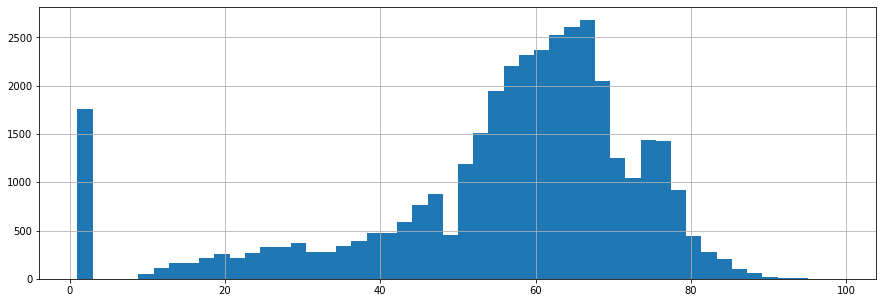

In [941]:
# Выведем график распределения выборки по возрасту
fig = plt.figure(figsize = (15,5))
train_data['age_parsing'].hist(bins = 50)

## Очистка текстов

Напишем фукнцию для очистки текстов от лишних символов

In [1215]:
# добавил вариант очистки без апострофа

def clear_text(text):
    clear_text = re.sub("[^A-Яа-я\n]+",' ', text).lower()
    return " ".join(clear_text.split())

# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

In [964]:
# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'зачем', 'еще', 'себя', 'чтоб', 'иногда', 'то', 'до', 'чтобы', 'об', 'быть', 'на', 'чего', 'было', 'все', 'что', 'здесь', 'один', 'потому', 'тот', 'всего', 'как', 'со', 'но', 'тут', 'им', 'даже', 'нет', 'надо', 'за', 'из', 'перед', 'мне', 'от', 'него', 'уже', 'ни', 'ней', 'впрочем', 'какая', 'ну', 'нас', 'бы', 'себе', 'чуть', 'мы', 'ли', 'у', 'о', 'мой', 'этот', 'этом', 'сейчас', 'после', 'и', 'может', 'всех', 'них', 'вдруг', 'наконец', 'ему', 'этого', 'была', 'вы', 'ведь', 'ничего', 'там', 'ж', 'том', 'или', 'под', 'тем', 'вас', 'нельзя', 'а', 'конечно', 'его', 'свою', 'их', 'ее', 'потом', 'над', 'если', 'я', 'будто', 'этой', 'всю', 'три', 'тогда', 'есть', 'совсем', 'с', 'такой', 'раз', 'почти', 'два', 'тебя', 'чем', 'больше', 'во', 'всегда', 'другой', 'какой', 'в', 'можно', 'нибудь', 'меня', 'будет', 'того', 'были', 'он', 'она', 'когда', 'ей', 'эту', 'никогда', 'тоже', 'много', 'ним', 'вам', 'про', 'уж', 'по', 'кто', 'хоть', 'куда', 'для', 'да', 'же', 'вот', 'ты', 'хорошо', 'н

## Получение полей содержащих наибольшее количество текста

In [1216]:
start = time.time()

max_text = {}

errors = []

for i in train_data.index:
    
    try:
        fields = [x.split(':') for x in train_data.iloc[i, 1].split('\n')]
    
    except:
        errors.append(i)
        print(i)
        max_text[i] = np.nan

    max_field = fields[np.argmax(np.array([len(x[0]) for x in fields]))][0]
    
    max_text[i] = max_field

print('Время обработки составило', int(time.time()-start), 'сек.')

79333
79334
79335
Время обработки составило 47 сек.


In [ ]:
train_data['max_text'] = pd.Series(max_text)

In [2268]:
start = time.time()

second_text = {}
third_text = {}

errors = []

for i in train_data.index:
    
    try:
        fields = [x.split(':') for x in train_data.iloc[i, 1].split('\n')]
    
    except:
        errors.append(i)
        print(i)
        max_text[i] = np.nan

    try:
        second_field = fields[pd.Series(np.array([len(x[0]) for x in fields])).sort_values(ascending = False).index[1]][0]
    except:
        second_field = np.nan
    try:
        third_field = fields[pd.Series(np.array([len(x[0]) for x in fields])).sort_values(ascending = False).index[2]][0]
    except:
        third_field = np.nan      
    
      
    second_text[i] = second_field
    third_text[i] = third_field

print('Время обработки составило', int(time.time()-start), 'сек.')

79333
79334
79335
Время обработки составило 111 сек.


In [2271]:
train_data['second_text'] = pd.Series(second_text)

train_data['third_text'] = pd.Series(third_text)

In [2273]:
# Протестируем работу функции очистки текста
text = train_data['second_text'][1]
print(text)
print('=======================================')
print(clean_stop_words((clear_text(text)), stopwords))

Пациент 71 года, с длительным анамнезом ГБ, с безболевой формой ишемии миокарда, ишемия верифицирована по даннфм стресс-ЭхоКГ, 18.01.16г- выполнена КАГ, определены показания к РТСА со стентированием ПМЖА. Регоспитализирован планово.
пациент года длительным анамнезом гб безболевой формой ишемии миокарда ишемия верифицирована даннфм стресс эхокг г выполнена каг определены показания ртса стентированием пмжа регоспитализирован планово


In [969]:
start_clean = time.time()
train_data['max_text'] = train_data['max_text'].apply(lambda x: clean_stop_words(clear_text(x), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 25.38 секунд


In [2278]:
train_data = train_data.dropna(subset = ['second_text', 'third_text'])

In [2280]:
start_clean = time.time()

train_data['second_text'] = train_data['second_text'].apply(lambda x: clean_stop_words(clear_text(x), stopwords))

train_data['third_text'] = train_data['third_text'].apply(lambda x: clean_stop_words(clear_text(x), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 4.07 секунд


In [2285]:
# Сохраним отдельно поля с текстами
train_text_data = train_data[['label', 'max_text', 'second_text', 'third_text']]

In [2286]:
train_text_data

,label,max_text,second_text,third_text
0,0.0,госпитализирован поводу данного заболевания те...,время поступления приемное отделение,дата поступления приемное отделение
1,0.0,повышение ад течение длительного времени макс ...,пациент года длительным анамнезом гб безболево...,поставленный диагноз возможность осложнений не...
2,0.0,анамнезе около лет гб max ад мм рт ст адаптиро...,пациент лет анамнезом гб жэ постинфарктным кар...,чувство жжения сжатия грудиной левой половине ...
3,0.0,боли правом подреберье беспокоят протяжении не...,больная nnnnnnnnn лет госпитализирована хирург...,году оперирована поводу недостаточности аортал...
4,0.0,флюорограмма контрольной рентгенограмме органо...,пациентка лет длительным анамнезом ибс перенес...,пациентка лет длительным анамнезом ибс перенес...
...,...,...,...,...
79331,0.0,госпитализирован поводу данного заболевания те...,считает больной течении последних ти месяцев,патологические кистевые знаки россолимо вендер...
79332,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...
79333,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...
79334,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...


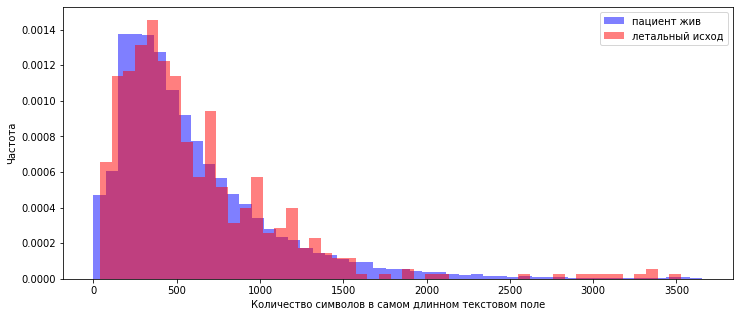

In [2634]:
# Выведем график распределения по длинне текста
fig = plt.figure(figsize = (12,5))
plt.hist(pd.Series([len(x) for x in train_data[train_data['label']==0]['max_text']]),
         bins = 50,
         alpha = 0.5,
         color = 'b',
         label = 'пациент жив',
        density=True)
plt.hist(pd.Series([len(x) for x in train_data[train_data['label']==1]['max_text']]),
         bins = 50,
         alpha = 0.5,
         color = 'r',
         label = 'летальный исход',
        density=True)
plt.xlabel('Количество символов в самом длинном текстовом поле')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [517]:
def shorter(column_text, max_lenght):
    '''
    Функция, которая обрезает текстовые значения в столбце датафрейма до предыдущего целого слова 
    указанной длинны с пробелами между словами  
    '''
    for x in column_text.index:
        if len(column_text[x]) > max_lenght:
            words_len = []
            for word in column_text[x].split():
                if len(" ".join(words_len)) < max_lenght:
                    words_len.append(word)
            column_text[x] = " ".join(words_len[:-1])
    return column_text

In [519]:
# обработаем тексты
shorter_start = time.time()
column_text = train_data['max_text'].copy()
train_data.loc[:,'shorter_1500'] = shorter(column_text, 1500)

print('Обработка текстов заняла: '+str(round(time.time() - shorter_start, 2))+' секунд')
train_data.head()

Обработка текстов заняла: 3.08 секунд


,id,text,label,n_fields,age_parsing,max_text,shorter_1500
0,0,"Температура тела : 36,5 С\nВеc, кг : 74 ,\nРос...",0.0,32,NaN,госпитализирован поводу данного заболевания те...,госпитализирован поводу данного заболевания те...
1,1,Педикулез : отр\nЧесотка : отр\nИБС СН 2фк\nДа...,0.0,45,71.0,повышение ад течение длительного времени макс ...,повышение ад течение длительного времени макс ...
2,2,"Температура тела : 36,4 С\nВеc, кг : 73 ,\nРос...",0.0,66,52.0,анамнезе около лет гб max ад мм рт ст адаптиро...,анамнезе около лет гб max ад мм рт ст адаптиро...
3,3,"Температура тела : 36,4 С\nВеc, кг : 92\nРост,...",0.0,70,NaN,боли правом подреберье беспокоят протяжении не...,боли правом подреберье беспокоят протяжении не...
4,4,Педикулез : отр\nЧесотка : отр\nФлюорограмма Н...,0.0,42,68.0,флюорограмма контрольной рентгенограмме органо...,флюорограмма контрольной рентгенограмме органо...


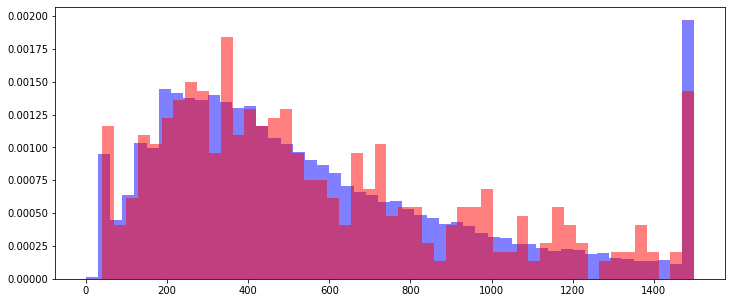

In [520]:
fig = plt.figure(figsize = (12,5))
plt.hist(pd.Series([len(x) for x in train_data[train_data['label']==0]['shorter_1500']]),
         bins = 50,
         alpha = 0.5,
         color = 'b',
        density=True)
plt.hist(pd.Series([len(x) for x in train_data[train_data['label']==1]['shorter_1500']]),
         bins = 50,
         alpha = 0.5,
         color = 'r',
        density=True)
plt.show()

In [561]:
for _ in range(3):
    display(train_data['shorter_1500'][np.random.randint(1,train_data.shape[0])])

'состояние удовлетворительное осмотр реагирует двигательной активностью эмоциональным плачем мышечный тонус физиологический большой родничок нормотоничен кожные покровы розовые чистые дыхание проводится симметрично х сторон хрипов тоны сердца ясные ритимчные живот вздут мягкий отделах перистальтика выслушивается анус типичном месте наружные половые органы женскому типу признаков воспаления стул диурез достаточный'

'ад выше \\ мм рт ст привычнфые физические нагрузки переносил года стали возникать редкие пароксизмы фп длящиеся минут возникающие правило утренние часы связанные нагрузкой проявляющиеся особыми субъективными ощущениями постоянно принимает аспирин беталок зок микардис течение последнего года пароксизмы стали возникать чаще дней длится также недолго купируются дополнительным приемом метопролола настоящий приступ возник сегодня просыпании предыдущих отличается появлением ноющих болей спине ит руках связанных ходьбой одышки кровохарканья потребности повышенном изголовьи испытывает длится настоящее время снятой экг фибрилляция предсердий умеренной тахисистолией желудочков полная блокада пнпг блокада передне верхней ветви лнпг очаговых изменений анализе крови гиперурикемия ттг норме эхокг иммлж увеличение лп глобальная сократимость сохранена нарушений локальной сократимости фоне проведенного лечения ночь восстановился синусовый ритм ад нормальное явлений сердечной недостаточности время лече

'состояние ребенка удовлетворительное лихорадит осомтр реагирует адекватно плач громкий эмоциональный большой родничок норматоничный уровне костных краев вскармливание естественное срыгиваний кожные покровы чистые бледно розового цвета дыхание проводится отделы равномерно сердечные тоны ясные ритмичные животмягкий отделах стул оформленный диурез достаточный'

## Предварительное обучение моделей     

Для каждого комментария сгенерируем его числовое представление техникой TF-IDF  (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста») которая каждому комментарию сопоставляет вектор.

Каждая компонента полученного вектора соответствует уникальному слову из словаря корпуса текстов, и принимает значение равное количеству вхождений этого слова в данный текст (TF) домноженному на коэффициент обратной частоты встречаемости этого слова во всем корпусе текстов (IDF).  

IDF рассчитывается, как логарифм от инверсиии вероятности встретить документ с данным словом в корпусе (обратная частота).

Таким образом если слово встречается почти в каждом документе, то обратная частота будет близка к единице, логарифм будет стремится к нулю и значение TF-IDF будет меньше. И наоборот для слов, которые уникальны для конкретного текста обратная частота будет стремится к значению количества текстов и соответственно будет расти значение логарифма, что будет давать большие значения для уникальных слов.

In [2653]:
train_text_data = pd.read_csv(path_main_dir+'\\train_text_data.csv',
                             index_col=0)

In [2654]:
train_text_data

,label,max_text,second_text,third_text
0,0.0,госпитализирован поводу данного заболевания те...,время поступления приемное отделение,дата поступления приемное отделение
1,0.0,повышение ад течение длительного времени макс ...,пациент года длительным анамнезом гб безболево...,поставленный диагноз возможность осложнений не...
2,0.0,анамнезе около лет гб max ад мм рт ст адаптиро...,пациент лет анамнезом гб жэ постинфарктным кар...,чувство жжения сжатия грудиной левой половине ...
3,0.0,боли правом подреберье беспокоят протяжении не...,больная nnnnnnnnn лет госпитализирована хирург...,году оперирована поводу недостаточности аортал...
4,0.0,флюорограмма контрольной рентгенограмме органо...,пациентка лет длительным анамнезом ибс перенес...,пациентка лет длительным анамнезом ибс перенес...
...,...,...,...,...
79331,0.0,госпитализирован поводу данного заболевания те...,считает больной течении последних ти месяцев,патологические кистевые знаки россолимо вендер...
79332,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...
79333,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...
79334,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...


In [2287]:
tf_idf_train = train_text_data.copy()

In [2288]:
tf_idf_train

,label,max_text,second_text,third_text
0,0.0,госпитализирован поводу данного заболевания те...,время поступления приемное отделение,дата поступления приемное отделение
1,0.0,повышение ад течение длительного времени макс ...,пациент года длительным анамнезом гб безболево...,поставленный диагноз возможность осложнений не...
2,0.0,анамнезе около лет гб max ад мм рт ст адаптиро...,пациент лет анамнезом гб жэ постинфарктным кар...,чувство жжения сжатия грудиной левой половине ...
3,0.0,боли правом подреберье беспокоят протяжении не...,больная nnnnnnnnn лет госпитализирована хирург...,году оперирована поводу недостаточности аортал...
4,0.0,флюорограмма контрольной рентгенограмме органо...,пациентка лет длительным анамнезом ибс перенес...,пациентка лет длительным анамнезом ибс перенес...
...,...,...,...,...
79331,0.0,госпитализирован поводу данного заболевания те...,считает больной течении последних ти месяцев,патологические кистевые знаки россолимо вендер...
79332,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...
79333,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...
79334,0.0,направлен п кой м гг перенес повторные онмк иш...,пациент лет перенесший повторные онмк псма гг ...,мышечная сила конечностях баллах отделсправасл...


In [2347]:
tf_idf_train = tf_idf_train.drop_duplicates(keep = 'first').dropna()

In [2428]:
# предварительно разделим выборку на тестовую и обучающую
train, test = train_test_split(tf_idf_train,
                        test_size = 0.2,
                        random_state = 12348,
                        #stratify = train_data['label']
                       )

print(train.shape)
print(test.shape)

(60694, 4)
(15174, 4)


In [2429]:
# Сравним распределение целевого признака
sets = [train, test]
for i in range(len(sets)):    
    print(sets[i][sets[i]['label'] == 1].shape[0] / sets[i].shape[0])

0.006475104623191749
0.006853828917885858


In [2441]:
def upsample_class(data, class_columns, class_label, coef):
    '''
    Функция увеличивающая долю строк указанного класса в наборе данных на указанный
    коэффициент
    '''

    upsampled_class = data[data[class_columns] == class_label].sample(
        frac = coef,
        replace = True,
        random_state = 12345
    )
    
    data_align = pd.concat([data[data[class_columns] != class_label], upsampled_class])
    data_align = data_align.sample(frac = 1, random_state = 12345)
    
    return data_align

In [2442]:
# Исскуственно увеличим количество положительного класса для обучения моделей
train_upsample = upsample_class(train, 'label', 1, 20)

In [2444]:
# Сравним распределение целевого признака
sets = [train_upsample, test]
for i in range(len(sets)):    
    print(sets[i][sets[i]['label'] == 1].shape[0] / sets[i].shape[0])

0.11531520957732427
0.006853828917885858


In [2445]:
# определим корпус текстов для тренировочного и тестового набора данных
corpus_train_1 = train_upsample['max_text'].values.astype('U')

corpus_train_2 = train_upsample['second_text'].values.astype('U')

corpus_train_3 = train_upsample['third_text'].values.astype('U')


corpus_test_1 = test['max_text'].values.astype('U')

corpus_test_2 = test['second_text'].values.astype('U')

corpus_test_3 = test['third_text'].values.astype('U')

In [2446]:
len(corpus_train_2)

68161

### Базовая логистическая регрессия на TF-IDF

Создадим baseline (базовый уровень), с которым будем сравнивать все последующие модели. Нашим бэйслайном будет набор признаков TF-IDF с параметрами рассчета по умолчанию, с логистической регрессией в качестве модели.

In [2350]:
# Получим списки IDF (inverse document frequency — обратная частота документа) отдельно для каждого класса

deaths = tf_idf_train[
                tf_idf_train['label']==1][[
                    'max_text',
                    'second_text',
                    'third_text',
                    'label']].dropna()
live = tf_idf_train[
                tf_idf_train['label']==0][[
                    'max_text',
                    'second_text',
                    'third_text',
                    'label']].dropna()

deaths_corpus = set(deaths['max_text'].values.astype('U'))\
                .union(set(deaths['second_text'].values.astype('U')))\
                .union(set(deaths['third_text'].values.astype('U')))

live_corpus = set(live['max_text'].values.astype('U'))\
                .union(set(live['second_text'].values.astype('U')))\
                .union(set(live['third_text'].values.astype('U')))

In [2354]:
count_idf_deaths = TfidfVectorizer(max_features = 2000)
count_idf_live = TfidfVectorizer(max_features = 2000)

tf_idf_deaths = count_idf_deaths.fit_transform(deaths_corpus)
tf_idf_live = count_idf_live.fit_transform(live_corpus)

In [2355]:
# Сохраним списки Idf для каждого класса
deaths_importance = pd.DataFrame(
    {'ключевое слово' : count_idf_deaths.get_feature_names_out(),
     'idf' : count_idf_deaths.idf_
    }).sort_values(by = 'idf', ascending = False)

live_importance = pd.DataFrame(
    {'ключевое слово' : count_idf_live.get_feature_names_out(),
     'idf' : count_idf_live.idf_
    }).sort_values(by = 'idf', ascending = False)

In [1034]:
live_importance.to_excel(path_main_dir+'\\live_keywords.xlsx')

In [1035]:
deaths_importance.to_excel(path_main_dir+'\\death_keywords.xlsx')

In [1948]:
deaths_importance = pd.read_csv(path_main_dir+'\\death_keywords_edit.csv')

In [1949]:
# Загрузим отфильтрованные в ручную ключевые слова для летальных исходов
edited_deaths_factors = (''.join(m.lemmatize('$$$$'.join(
                        deaths_importance['ключевое слово']))))\
                        .split('$$$$')

In [2409]:
len(edited_deaths_factors)

327

In [2410]:
# Объединим наборы слов в единый словарь
vocab = set(edited_deaths_factors)\
            .union(live_importance['ключевое слово'].values)

In [2447]:
# Выведем общую длину словаря
len(vocab)

2139

In [2448]:
# По полученному словарю получим векторные представления записей о пациентах
count_idf_distilate = TfidfVectorizer(vocabulary = vocab)

In [2449]:
tf_idf_train_base_1 = count_idf_distilate.fit_transform(corpus_train_1)
tf_idf_test_base_1 = count_idf_distilate.transform(corpus_test_1)

tf_idf_train_base_2 = count_idf_distilate.fit_transform(corpus_train_2)
tf_idf_test_base_2 = count_idf_distilate.transform(corpus_test_2)

tf_idf_train_base_3 = count_idf_distilate.fit_transform(corpus_train_3)
tf_idf_test_base_3 = count_idf_distilate.transform(corpus_test_3)

In [2450]:
display(tf_idf_test_base_1.shape)
display(tf_idf_train_base_1.shape)

(15174, 2139)

(68161, 2139)

In [2471]:
tf_idf_test_base = sparse.hstack((
                                tf_idf_test_base_1,
                                    ))

In [2472]:
tf_idf_train_base = sparse.hstack((
    tf_idf_train_base_1,
))

In [2473]:
display(tf_idf_test_base.shape)
display(tf_idf_train_base.shape)

(15174, 2139)

(68161, 2139)

In [ ]:
# Проведем предварительное обучение модели классификации

In [2474]:
model_lr_base = LogisticRegression(solver = 'lbfgs',
                                      random_state = 12345,
                                      max_iter= 10000,
                                      n_jobs= -1)

In [1680]:
cv_lr_base = cross_validate(model_lr_base,
                            tf_idf_train_base,
                            train_upsample['label'],
                            scoring = make_scorer(balanced_accuracy_score),
                            return_train_score = True,
                            return_estimator = True,                            
                            cv = 3)

# выведем F-1 меру для нашего бэйслайна
f1_lr_base = np.mean(cv_lr_base['test_score'])
f1_lr_base

0.5781884161494074

In [ ]:
# Получим прогноз и оценим качество модели

In [2523]:
model_lr_base.fit(tf_idf_train_base, train_upsample['label'])

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [2476]:
predict_lr_base = model_lr_base.predict(tf_idf_test_base)

In [2477]:
predict_lr_base_proba = model_lr_base.predict_proba(tf_idf_test_base)

In [2529]:
confusion_matrix(test['label'],
                 (predict_lr_base_proba[:, 1] > 0.04).astype('float'),
                 #predict_lr_base,
                 normalize='true',
                )

array([[0.5270073 , 0.4729927 ],
       [0.41346154, 0.58653846]])

In [2479]:
roc_auc_score(test['label'], (predict_lr_base_proba[:, 1] > 0.04).astype('float'))

0.5567728804042673

In [2480]:
balanced_accuracy_score(test['label'], (predict_lr_base_proba[:, 1] > 0.04).astype('float'))

0.5567728804042673

## Визуализация важности признаков

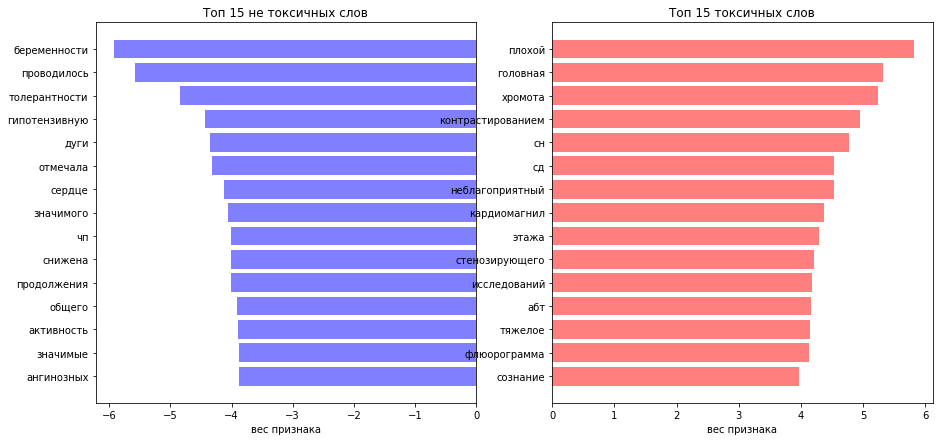

In [2648]:
weights = pd.DataFrame({'words': count_idf_distilate.get_feature_names(), 'weights': model_lr_base.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')
weights_max = weights.sort_values(by= 'weights', ascending = False)

fig, axs = plt.subplots(1, 2, figsize = (15, 7))

axs[0].barh(weights_min.head(15).sort_values(by = 'weights', ascending = False)['words'],
          weights_min.head(15).sort_values(by = 'weights', ascending = False)['weights'],
            color = 'b',
            alpha = 0.5
          )
axs[1].barh(weights_max.head(15).sort_values(by = 'weights', ascending = True)['words'],
           weights_max.head(15).sort_values(by = 'weights', ascending = True)['weights'],
            color = 'r',
            alpha = 0.5
          )
axs[0].set_xlabel('вес признака')
axs[1].set_xlabel('вес признака')
axs[0].set_title('Топ 15 не токсичных слов')
axs[1].set_title('Топ 15 токсичных слов')
plt.show()

## Градиентный бустинг на TF-IDF

In [ ]:
best_n = 0
best_f1_lgb = 0
best_cv_lgb = 0

for n in range(10,100, 10):   

    
    model_lgb = LGBMClassifier(n_estimators = n,
                               random_state = 12345,
                               n_jobs= -1,
                               reg_lambda = reg
                              )

    cv_lgb = cross_validate(model_lgb,
                                tf_idf_train_base,
                                train_upsample['label'],
                                scoring = make_scorer(balanced_accuracy_score),
                                return_train_score = True,
                                return_estimator = True,                            
                                cv = 3)

    acc_lgb = np.mean(cv_lgb['test_score'])
    
    test_score = balanced_accuracy_score(
        test['label'],
        cv_lgb['estimator'][0].predict(tf_idf_test_base))
    
     
    print('n '+str(n))
    print('balanced_accuracy_score '+str(acc_lgb))
    print('test metric ',test_score)
    
    

    if acc_lgb > best_f1_lgb:
        best_f1_lgb = acc_lgb
        best_n = n
        best_cv_lgb = cv_lgb       


run_time_fit_lgb = best_cv_lgb['fit_time'].mean()
run_time_pred_lgb = best_cv_lgb['score_time'].mean()
        
print("Лучшее количество деревьев lgb :", best_n)
print('Время обучения лучшей модели: '+str(round(run_time_fit_lgb, 4))+' секунд')
print('Время получения прогноза лучшей модели: '+str(round(run_time_pred_lgb, 4))+' секунд')
print('balanced_accuracy_score лучшей модели LGBMClassifier на тренировочном наборе данных: '+str(best_f1_lgb))

## Подбор параметров логистрической регрессии

In [2522]:
best_n = 0
best_f1_lgb = 0
best_cv_lgb = 0

for n in np.linspace(0.1, 0.8, 5):   

    
    model_lgb = LogisticRegression(solver = 'saga',
                                      random_state = 12345,
                                      max_iter= 10000,
                                   l1_ratio= n,
                                      n_jobs= -1,
                                   penalty = 'elasticnet'
                                  )

    cv_lgb = cross_validate(model_lgb,
                                tf_idf_train_base,
                                train_upsample['label'],
                                scoring = make_scorer(balanced_accuracy_score),
                                return_train_score = True,
                                return_estimator = True,                            
                                cv = 3)

    acc_lgb = np.mean(cv_lgb['test_score'])
    
    test_score = balanced_accuracy_score(
        test['label'],
        cv_lgb['estimator'][0].predict(tf_idf_test_base))
    
     
    print('n '+str(n))
    print('balanced_accuracy_score '+str(acc_lgb))
    print('test metric ',test_score)
    
    

    if test_score > best_f1_lgb:
        best_f1_lgb = test_score
        best_n = n
        best_cv_lgb = cv_lgb       


run_time_fit_lgb = best_cv_lgb['fit_time'].mean()
run_time_pred_lgb = best_cv_lgb['score_time'].mean()
        
print("Лучшее n :", best_n)
print('Время обучения лучшей модели: '+str(round(run_time_fit_lgb, 4))+' секунд')
print('Время получения прогноза лучшей модели: '+str(round(run_time_pred_lgb, 4))+' секунд')
print('метрика лучшей модели на тестовом наборе данных: '+str(best_f1_lgb))

n 0.1
balanced_accuracy_score 0.6510394561223748
test metric  0.5156806696952683
n 0.275
balanced_accuracy_score 0.6587895185873314
test metric  0.5198579704966566
n 0.45000000000000007
balanced_accuracy_score 0.6699470998241003
test metric  0.5192939359910163
n 0.625
balanced_accuracy_score 0.6927710382564757
test metric  0.5231394517890868
n 0.8
balanced_accuracy_score 0.721090846711303
test metric  0.5219118472768107
Лучшее n : 0.625
Время обучения лучшей модели: 7.4975 секунд
Время получения прогноза лучшей модели: 0.0196 секунд
метрика лучшей модели на тестовом наборе данных: 0.5231394517890868


## Повторное обучение моделей

### Загрузка предобработки признаков выполненной коллегами по комманде

In [875]:
parse_data = pd.read_excel(path_main_dir+'\\alex_parse\\df_pr_excel.xlsx',
                             sheet_name=0)

In [1689]:
parse_icd_data = pd.read_csv(path_main_dir + "\\valentin_parse\\icd_brute.csv")

In [1702]:
parse_icd_data.columns = ['id', 'icd']
parse_icd_data

,id,icd
0,0,I20.8
1,1,I25.6
2,2,I20.8
3,5,I20.8
4,12,I44.2
...,...,...
46963,79330,K40.9
46964,79331,D25
46965,79332,M12.5
46966,79333,M51.1


In [1688]:
parse_point_data = pd.read_csv(path_main_dir + "\\valentin_parse\\tsel_encoded.csv")

In [1704]:
parse_point_data.columns = ['id', 'point']
parse_point_data

,id,point
0,0,0
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
76395,79331,1
76396,79332,0
76397,79333,0
76398,79334,1


In [1758]:
preprocessed_train = train_data.drop_duplicates(subset = ['max_text'], keep = 'first')

In [1759]:
preprocessed_train.columns

Index(['id', 'text', 'label', 'id parse', 'sex', 'weight', 'height', 'puls',
       'ad_s', 'ad_d', 'diabet2', 'sam_prishel', 'ekg_PQ', 'ekg_QRS', 'ekg_QT',
       'dmarkers', 'bmi', 'n_fields', 'age_parsing', 'max_text',
       'max_text_lemmed'],
      dtype='object')

In [1760]:
preprocessed_train = preprocessed_train.drop(['id parse','ekg_PQ', 'ekg_QRS', 'ekg_QT'], axis = 1)

In [1761]:
preprocessed_train = preprocessed_train\
                        .set_index('id')\
                        .join(parse_icd_data.set_index('id'), how = 'left')\
                        .join(parse_point_data.set_index('id'), how = 'left')

In [1762]:
preprocessed_train = preprocessed_train.drop(['text', 'max_text_lemmed'], axis = 1)

## Добавление признаков

Добавим в качестве признака прогноз модели построенной на векторных представления текста

In [2570]:
all_train_tf_idf = count_idf_distilate.fit_transform(preprocessed_train['max_text'].values)

In [2571]:
all_train_tf_idf.shape

(69902, 2139)

In [2572]:
tf_idf_feature = model_lr_base.predict_proba(all_train_tf_idf)

In [2573]:
preprocessed_train['tf_idf_feature'] = tf_idf_feature[:, 1]

In [1806]:
preprocessed_train

,label,sex,weight,height,puls,ad_s,ad_d,diabet2,sam_prishel,bmi,n_fields,age_parsing,max_text,icd,point,tf_idf_feature
id,,,,,,,,,,,,,,,,
0,0.0,NaN,74.0,176.0,NaN,NaN,NaN,0.0,1.0,23.889463,32.0,NaN,госпитализирован поводу данного заболевания те...,I20.8,0.0,0.050718
1,0.0,1.0,NaN,NaN,68.0,130.0,90.0,0.0,1.0,NaN,45.0,71.0,повышение ад течение длительного времени макс ...,I25.6,1.0,0.018241
2,0.0,1.0,73.0,174.0,58.0,125.0,80.0,0.0,1.0,24.111507,66.0,52.0,анамнезе около лет гб max ад мм рт ст адаптиро...,I20.8,0.0,0.233883
3,0.0,NaN,92.0,165.0,NaN,NaN,NaN,0.0,1.0,33.792470,70.0,NaN,боли правом подреберье беспокоят протяжении не...,NaN,0.0,0.079772
4,0.0,0.0,NaN,NaN,70.0,110.0,80.0,0.0,1.0,NaN,42.0,68.0,флюорограмма контрольной рентгенограмме органо...,NaN,1.0,0.118925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79330,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,63.0,NaN,больной бондаренко nnnnnnnnn лет поступил х це...,K40.9,1.0,0.102802
79331,0.0,0.0,65.0,165.0,65.0,110.0,70.0,0.0,1.0,23.875115,108.0,61.0,пищеварительная система наружное паховое кольц...,D25,1.0,0.020902
79333,0.0,1.0,58.0,174.0,72.0,120.0,80.0,0.0,1.0,19.157088,44.0,NaN,дискомфорт течение полугода усиливается ходьбе...,M51.1,0.0,0.044585


Очистим датасет от лишних столбцов

In [1799]:
preprocessed_train  = preprocessed_train.drop(['dmarkers'], axis = 1)

Приведем числовые значения к одному формату

In [1789]:
preprocessed_train['weight'] = pd.to_numeric(preprocessed_train['weight'], errors = 'coerce')

In [1791]:
preprocessed_train['height'] = pd.to_numeric(preprocessed_train['height'], errors = 'coerce')

In [1793]:
preprocessed_train['bmi'] = pd.to_numeric(preprocessed_train['bmi'], errors = 'coerce')

Загрузим парсинг признаков

In [1809]:
sost = pd.read_csv(path_main_dir+"\\valentin_parse\\sost.csv")

In [1818]:
icd_deaths = pd.read_csv(path_main_dir+'\\death_icd.csv')

In [1820]:
icd_deaths.columns = ['id', 'icd']
icd_deaths

,id,icd
0,254,I25.5
1,633,I
2,1055,I
3,1087,I08.3
4,1388,I
...,...,...
497,78368,I67.1
498,78372,I35.0
499,78551,I67.1
500,78864,I20.8


In [1847]:
# Получим первую букву из классификации МКБ
icd_letter = pd.DataFrame(
    [re.split(r'(\w)', (x[0]))[1] for x in preprocessed_train['icd'].dropna()],
    index = preprocessed_train['icd'].dropna().index,
    columns = ['icd_letter']
)

In [1853]:
icd_deaths = icd_deaths.set_index('id')

In [1854]:
icd_deaths_letter = pd.DataFrame(
    [re.split(r'(\w)', (x[0]))[1] for x in icd_deaths['icd'].dropna()],
    index = icd_deaths['icd'].dropna().index,
    columns = ['icd_letter']
)

In [1858]:
icd_letter = pd.concat([icd_letter, icd_deaths_letter])

In [1863]:
preprocessed_train = preprocessed_train.join(icd_letter, how = 'left')

Добавим информацию о состоянии больного

In [1811]:
sost.columns = ['id', 'patient_status']

In [1865]:
sost['patient_status'].value_counts()

0.0    65072
1.0     4057
Name: patient_status, dtype: int64

In [1867]:
preprocessed_train = preprocessed_train.join(sost, how = 'left')

In [1874]:
preprocessed_train = preprocessed_train.drop('icd', axis = 1)

In [1875]:
preprocessed_train.dtypes

label             float64
sex               float64
weight            float64
height            float64
puls              float64
ad_s              float64
ad_d              float64
diabet2           float64
sam_prishel       float64
bmi               float64
n_fields          float64
age_parsing       float64
max_text           object
point             float64
tf_idf_feature    float64
icd_letter         object
id                float64
patient_status    float64
dtype: object

In [1876]:
preprocessed_train.isna().sum(axis = 0)/preprocessed_train.shape[0]

label             0.000014
sex               0.230351
weight            0.201682
height            0.179437
puls              0.293153
ad_s              0.260794
ad_d              0.262067
diabet2           0.000029
sam_prishel       0.000043
bmi               0.202054
n_fields          0.000000
age_parsing       0.497167
max_text          0.000000
point             0.037452
tf_idf_feature    0.000000
icd_letter        0.407728
id                0.128795
patient_status    0.129066
dtype: float64

In [1877]:
preprocessed_train.query('label ==1').isna().sum(axis = 0)/preprocessed_train.query('label ==1').shape[0]

label             0.000000
sex               0.254848
weight            0.220222
height            0.202216
puls              0.299169
ad_s              0.282548
ad_d              0.282548
diabet2           0.000000
sam_prishel       0.000000
bmi               0.227147
n_fields          0.000000
age_parsing       0.487535
max_text          0.000000
point             0.059557
tf_idf_feature    0.000000
icd_letter        0.002770
id                0.180055
patient_status    0.180055
dtype: float64

In [1878]:
preprocessed_train.dropna().shape

(9854, 18)

In [1879]:
preprocessed_train.query('label ==1').dropna().shape

(158, 18)

In [1975]:
preprocessed_train.head()

,label,sex,weight,height,puls,ad_s,ad_d,diabet2,sam_prishel,bmi,n_fields,age_parsing,max_text,point,tf_idf_feature,icd_letter,id,patient_status
0,0.0,NaN,74.0,176.0,NaN,NaN,NaN,0.0,1.0,23.889463,32.0,NaN,госпитализирован поводу данного заболевания те...,0.0,0.694392,I,0.0,0.0
1,0.0,1.0,NaN,NaN,68.0,130.0,90.0,0.0,1.0,NaN,45.0,71.0,повышение ад течение длительного времени макс ...,1.0,0.023749,I,1.0,0.0
2,0.0,1.0,73.0,174.0,58.0,125.0,80.0,0.0,1.0,24.111507,66.0,52.0,анамнезе около лет гб max ад мм рт ст адаптиро...,0.0,0.322713,I,2.0,0.0
3,0.0,NaN,92.0,165.0,NaN,NaN,NaN,0.0,1.0,33.792470,70.0,NaN,боли правом подреберье беспокоят протяжении не...,0.0,0.020819,NaN,5.0,0.0
4,0.0,0.0,NaN,NaN,70.0,110.0,80.0,0.0,1.0,NaN,42.0,68.0,флюорограмма контрольной рентгенограмме органо...,1.0,0.033280,NaN,6.0,0.0


In [1976]:
height_weight = pd.read_csv(path_main_dir+'\\train_h+w.csv')

In [1977]:
height = height_weight[['height']]
weight = height_weight[['weight']]

In [1993]:
preprocessed_train['height'] = height['height']

In [1991]:
preprocessed_train['weight'] = weight['weight']

In [1997]:
preprocessed_train.isna().sum(axis = 0) / preprocessed_train.shape[0]

label             0.000014
sex               0.230351
weight            0.174087
height            0.178765
puls              0.293153
ad_s              0.260794
ad_d              0.262067
diabet2           0.000029
sam_prishel       0.000043
bmi               0.202054
n_fields          0.000000
age_parsing       0.497167
max_text          0.000000
point             0.037452
tf_idf_feature    0.000000
icd_letter        0.407728
id                0.128795
patient_status    0.129066
dtype: float64

In [2071]:
preprocessed_train.query('label == 1').isna().sum(axis = 0) / preprocessed_train.query('label == 1').shape[0]

label             0.000000
sex               0.254848
weight            0.159280
height            0.202216
puls              0.299169
ad_s              0.282548
ad_d              0.282548
diabet2           0.000000
sam_prishel       0.000000
bmi               0.227147
n_fields          0.000000
age_parsing       0.487535
max_text          0.000000
point             0.059557
tf_idf_feature    0.000000
icd_letter        0.002770
patient_status    0.180055
dtype: float64

In [2072]:
preprocessed_train.dropna()['label'].value_counts()

0.0    8591
1.0     146
Name: label, dtype: int64

In [2070]:
preprocessed_train = preprocessed_train.drop('id', axis = 1)

 ## Предобработка валидационного датасета

In [ ]:
valid = pd.rea_csv()

In [1880]:
# Загрузим таблицу с данными
valid_data = pd.read_csv(path_main_dir+'\\val.csv')

In [1884]:
valid_data = valid_data.drop_duplicates(subset = ['id'], keep = 'first')

In [1886]:
valid_data = valid_data.set_index('id')

In [1888]:
valid_data['label'].value_counts()

0    16872
1      129
Name: label, dtype: int64

### Очистка и лемматизация текстов

Напишем фукнцию для очистки текстов от лишних символов

In [1215]:
# добавил вариант очистки без апострофа

def clear_text_with_apostrof(text):
    clear_text = re.sub("[^A-Яа-я\n']+",' ', text).lower()
    return " ".join(clear_text.split())

def clear_text(text):
    clear_text = re.sub("[^A-Яа-я\n]+",' ', text).lower()
    return " ".join(clear_text.split())

# напишем функцию приводящую слова в исходную форму
def lemmatize(text):
    m = Mystem()
    lemm_list = [m.lemmatize(word)[0] for word in text.split()]
    return " ".join(lemm_list)

def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

In [964]:
# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'зачем', 'еще', 'себя', 'чтоб', 'иногда', 'то', 'до', 'чтобы', 'об', 'быть', 'на', 'чего', 'было', 'все', 'что', 'здесь', 'один', 'потому', 'тот', 'всего', 'как', 'со', 'но', 'тут', 'им', 'даже', 'нет', 'надо', 'за', 'из', 'перед', 'мне', 'от', 'него', 'уже', 'ни', 'ней', 'впрочем', 'какая', 'ну', 'нас', 'бы', 'себе', 'чуть', 'мы', 'ли', 'у', 'о', 'мой', 'этот', 'этом', 'сейчас', 'после', 'и', 'может', 'всех', 'них', 'вдруг', 'наконец', 'ему', 'этого', 'была', 'вы', 'ведь', 'ничего', 'там', 'ж', 'том', 'или', 'под', 'тем', 'вас', 'нельзя', 'а', 'конечно', 'его', 'свою', 'их', 'ее', 'потом', 'над', 'если', 'я', 'будто', 'этой', 'всю', 'три', 'тогда', 'есть', 'совсем', 'с', 'такой', 'раз', 'почти', 'два', 'тебя', 'чем', 'больше', 'во', 'всегда', 'другой', 'какой', 'в', 'можно', 'нибудь', 'меня', 'будет', 'того', 'были', 'он', 'она', 'когда', 'ей', 'эту', 'никогда', 'тоже', 'много', 'ним', 'вам', 'про', 'уж', 'по', 'кто', 'хоть', 'куда', 'для', 'да', 'же', 'вот', 'ты', 'хорошо', 'н

### Получение полей содержащих наибольшее количество текста

In [1897]:
start = time.time()

max_text = {}

errors = []

for i in valid_data.index:
    
    try:
        fields = [x.split(':') for x in valid_data.iloc[i, 0].split('\n')]
    
    except:
        errors.append(i)
        print(i)
        max_text[i] = np.nan

    max_field = fields[np.argmax(np.array([len(x[0]) for x in fields]))][0]
    
    max_text[i] = max_field

print('Время обработки составило', int(time.time()-start), 'сек.')

Время обработки составило 1 сек.


In [1900]:
pd.Series(max_text)[15000]

'Длительный анамнез ГБ, АД максимально 180/? мм.р.ст, адаптирован к 105-115/60-70 мм.рт.ст.ОНМК и ИМ в анамнезе отрицает.С 2015г - СД, на ПСПП, с 12.2017г на ПСПП+инсулинотерапия.В 2011г - оперативное лечение+лучевая терапия по поводу Сr мочевого пузыря, тогда же проводилось контраст - индуцированное исследование, на которое имела место аллергическая реакция. В 2011-2012г - набрал вес с 80 до 112кг.С 2015г - клиника стенокардии напряжения. В апреле 2017г - клиника стенокардии в покое, на фоне оптимизации медикаментозной терапии стабилизация стенокардии на уровне 3 ф.к. В настояще время - клиника стабильной стенокардии напряжения 3 ф.к. В связи с аллергической реакцией на йодсодержащие вещества АКГ по м\\жительства не выполнялась. Проба с ф.н. на тредмиле от 30.05.17г - ишемический тест сомнительный. ЭХОКГ от 16.05.17г - ЛП 43*35*52, КДР/КСР ЛЖ 48/34 мм , МН 1-2ст, СДЛА 22, без зон нарушений локальной сократимости, выпота в полости перикарда нет.Госпитализирован для дообследования и опр

In [1901]:
valid_data['max_text'] = pd.Series(max_text)

In [1903]:
# Протестируем работу функции
print(valid_data['max_text'][1])
print('=======================================')
print(clean_stop_words(clear_text(valid_data['max_text'][1]), stopwords))

Знает о повышение АД в течение 20 лет, макс АД 200/100, адаптирована к АД 120- 130/80. С 2008г. стали беспокоить нарушения ритма в виде ФП, были эпизоды потерь сознания. По данным СМ ЭКГ на фоне постоянной тахисистолической ФП, нарушение АV проведения, паузы более 2,5сек. Пациентка консультирована аритмологом, определены показания для имплантации ПЭКС. В 2009г. имплантация ПЭКС в режиме VVIR С 2009 отмечает снижение ТФН. В 2012 году проходила стационарное лечение в ФМИЦ, в связи с появлением спонтанных гематом, МНО более 4. Проводился подбор дозы варфарина с положительным эффектом. В дальнейшем наблюдалась у гематолога по месту жительства, поставлен диагноз гемолитическая анемия, лабораторная ремиссия. Уровень гемоглобина от 25.12.2017 - 104г/л.При амбулаторном обследовании на ЭКГ от 01/04/15 косонисходящая депрессия ST V1-V5, такая же ЭКГ от 02/04/15, клиники стенокардии пациентка не описывала.С лета 2017 года отмечает прогрессирование одышки, значимое снижение ТФН, появление головокр

In [1904]:
start_clean = time.time()
valid_data['max_text'] = valid_data['max_text'].apply(lambda x: clean_stop_words(clear_text(x), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 1.27 секунд


In [1906]:
valid_data['max_text'][valid_data['max_text'].duplicated()]

id
8        длительный анамнез гипертонической болезни мак...
82       госпитализирован поводу данного заболевания те...
147      длительный анамнез гипертонической болезни мак...
175      страдает ревматоидным артритом года получала п...
217      считает больным яеваря года впервые обратил вн...
                               ...                        
16976    сознание ясное температура тела состояние удов...
16978    объективный статус общее состояние удовлетвори...
16987    объективный статус общее состояние удовлетвори...
16990    объективный статус общее состояние удовлетвори...
16992    объективный статус общее состояние удовлетвори...
Name: max_text, Length: 2165, dtype: object

In [1907]:
valid_data = valid_data.drop_duplicates(subset = ['max_text'], keep = 'first')

<AxesSubplot:>

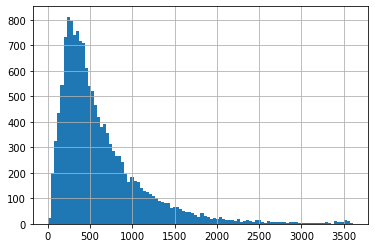

In [1914]:
pd.Series([len(x) for x in valid_data['max_text']]).hist(bins = 100)

In [1908]:
valid_data

,text,label,max_text
id,,,
0,"Температура тела : 36,5 С\nВеc, кг : 82\nРост,...",0,декабре года появились жалобы периодически воз...
1,"Температура тела : 36,6 С\nВеc, кг : 87\nРост,...",0,знает повышение ад течение лет макс ад адаптир...
2,"Температура тела : 36,6 С\nВеc, кг : 106,\nРос...",0,длительный анамнез артериальной гипертензии ма...
3,"Температура тела : 36,8 С\nВеc, кг : 108\nРост...",0,длительный анамнез артериальной гипертензии ма...
4,"Температура тела : 36,6 С\nВеc, кг : 105\nРост...",0,длительно повышаются цифры ад максимально мм р...
...,...,...,...
16996,"Температура тела : 36,6 С\nВеc, кг : 67\nРост,...",0,считает больной сентября года нервного напряже...
16997,"Температура тела : 36,6 С\nВеc, кг : 55\nРост,...",0,считает больной длительное время впервые стала...
16998,"Температура тела : 36,6 С\nВеc, кг : 90\nРост,...",0,считает больным года впервые потерял сознание ...


### Получение векторных представлений

In [1915]:
tf_idf_valid = valid_data[['max_text', 'label']]

In [1918]:
tf_idf_valid

,max_text,label
id,,
0,декабре года появились жалобы периодически воз...,0
1,знает повышение ад течение лет макс ад адаптир...,0
2,длительный анамнез артериальной гипертензии ма...,0
3,длительный анамнез артериальной гипертензии ма...,0
4,длительно повышаются цифры ад максимально мм р...,0
...,...,...
16996,считает больной сентября года нервного напряже...,0
16997,считает больной длительное время впервые стала...,0
16998,считает больным года впервые потерял сознание ...,0


In [1917]:
tf_idf_valid = tf_idf_valid.drop_duplicates(keep = 'first').dropna()

In [2564]:
valid_tf_idf = count_idf_distilate.transform(tf_idf_valid['max_text'].values)

In [2565]:
valid_tf_idf.shape

(14836, 2139)

In [2566]:
tf_idf_feature_val = model_lr_base.predict_proba(valid_tf_idf)

In [2567]:
valid_data['tf_idf_feature'] = tf_idf_feature_val[:, 1]

### Добавление признаков

In [2000]:
preprocessed_train.columns

Index(['label', 'sex', 'weight', 'height', 'puls', 'ad_s', 'ad_d', 'diabet2',
       'sam_prishel', 'bmi', 'n_fields', 'age_parsing', 'max_text', 'point',
       'tf_idf_feature', 'icd_letter', 'id', 'patient_status'],
      dtype='object')

In [2002]:
val_height = pd.read_csv(r"C:\Users\IvanovNikita\OneDrive - ООО «АЛЬМА Сервисез Компани»\Рабочий стол\rosminzdrav-dataset\val_h+w.csv")

In [2004]:
valid_data.columns

Index(['text', 'label', 'max_text', 'tf_idf_feature'], dtype='object')

In [2005]:
preprocessed_valid = valid_data[['label', 'max_text', 'tf_idf_feature']]

In [2006]:
preprocessed_valid

,label,max_text,tf_idf_feature
id,,,
0,0,декабре года появились жалобы периодически воз...,0.016567
1,0,знает повышение ад течение лет макс ад адаптир...,0.419361
2,0,длительный анамнез артериальной гипертензии ма...,0.033193
3,0,длительный анамнез артериальной гипертензии ма...,0.004059
4,0,длительно повышаются цифры ад максимально мм р...,0.016219
...,...,...,...
16996,0,считает больной сентября года нервного напряже...,0.070031
16997,0,считает больной длительное время впервые стала...,0.504261
16998,0,считает больным года впервые потерял сознание ...,0.329256


In [2007]:
val_height = val_height.set_index('id')

In [2010]:
preprocessed_valid = preprocessed_valid.join(val_height, how = 'left')

In [2011]:
preprocessed_valid.isna().sum(axis = 0)

label                 0
max_text              0
tf_idf_feature        0
sex                4558
weight             2431
height             3229
puls               4786
ad_s               4088
ad_d               4099
diabet2               1
sam_prishel           1
ekg_PQ            12689
ekg_QRS           12453
ekg_QT            12469
dmarkers             14
bmi                3928
dtype: int64

In [2014]:
preprocessed_valid = preprocessed_valid[['label', 'sex', 'weight', 'height', 'puls', 'ad_s', 'ad_d', 'diabet2',
       'sam_prishel', 'bmi', 'max_text', 'tf_idf_feature']]

#### Добавление количества заполненных полей

In [2020]:
# Выведем количество заполненных полей каждого пациента
n_columns = {}
errors_rows = []
for row in valid_data.index:
    try:
        n_columns[row] = (len(valid_data.loc[row, 'text'].split('\n')))
    except:
        errors_rows.append(row)
        n_columns[row] = np.nan

<AxesSubplot:>

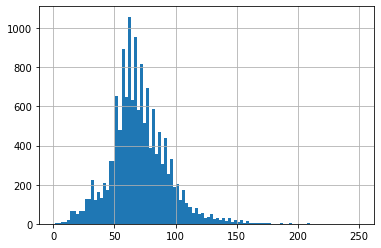

In [2022]:
pd.Series(n_columns).hist(bins = 100)

In [2029]:
preprocessed_valid = preprocessed_valid\
                    .join(pd.DataFrame(
                        n_columns.values(),
                        n_columns.keys(),
                        columns = ['n_fields']),
                          how = 'left')

In [2030]:
preprocessed_valid[['n_fields', 'label']].corr()

,n_fields,label
n_fields,1.000000,0.016173
label,0.016173,1.000000


In [2073]:
preprocessed_train.columns.difference(preprocessed_valid.columns)

Index(['age_parsing'], dtype='object')

#### Добавления кода МКБ

In [2035]:
icd_val = pd.read_csv(r"C:\Users\IvanovNikita\OneDrive - ООО «АЛЬМА Сервисез Компани»\Рабочий стол\rosminzdrav-dataset\valentin_parse\icd_brute_val.csv")

In [2038]:
icd_val.columns = ['id', 'icd']
icd_val = icd_val.set_index('id')

In [2039]:
# Получим первую букву из классификации МКБ
icd_letter = pd.DataFrame(
    [re.split(r'(\w)', (x[0]))[1] for x in icd_val['icd'].dropna()],
    index = icd_val['icd'].dropna().index,
    columns = ['icd_letter']
)

In [2041]:
preprocessed_valid = preprocessed_valid.join(icd_letter, how = 'left')

#### Добавления цели госпитализации

In [2046]:
point = pd.read_csv(r"C:\Users\IvanovNikita\OneDrive - ООО «АЛЬМА Сервисез Компани»\Рабочий стол\rosminzdrav-dataset\valentin_parse\tsel_encoded_val.csv")

In [2047]:
point.columns = ['id', 'point']
point = point.set_index('id')

In [2048]:
point

,point
id,
0,1
1,0
2,0
4,0
5,0
...,...
16996,0
16997,1
16998,0


In [2050]:
preprocessed_valid = preprocessed_valid.join(point, how = 'left')

#### Добавления статуса больного

In [2059]:
status = pd.read_csv(r"C:\Users\IvanovNikita\OneDrive - ООО «АЛЬМА Сервисез Компани»\Рабочий стол\rosminzdrav-dataset\valentin_parse\sost_val.csv")

In [2060]:
status.columns = ['id', 'patient_status']

status = status.set_index('id')

In [2061]:
preprocessed_valid = preprocessed_valid.join(status, how = 'left')

#### Парсинг возраста

In [2568]:
valid_data

,text,label,max_text,tf_idf_feature
id,,,,
0,"Температура тела : 36,5 С\nВеc, кг : 82\nРост,...",0,декабре года появились жалобы периодически воз...,0.038095
1,"Температура тела : 36,6 С\nВеc, кг : 87\nРост,...",0,знает повышение ад течение лет макс ад адаптир...,0.212166
2,"Температура тела : 36,6 С\nВеc, кг : 106,\nРос...",0,длительный анамнез артериальной гипертензии ма...,0.068694
3,"Температура тела : 36,8 С\nВеc, кг : 108\nРост...",0,длительный анамнез артериальной гипертензии ма...,0.001505
4,"Температура тела : 36,6 С\nВеc, кг : 105\nРост...",0,длительно повышаются цифры ад максимально мм р...,0.002604
...,...,...,...,...
16996,"Температура тела : 36,6 С\nВеc, кг : 67\nРост,...",0,считает больной сентября года нервного напряже...,0.132548
16997,"Температура тела : 36,6 С\nВеc, кг : 55\nРост,...",0,считает больной длительное время впервые стала...,0.067875
16998,"Температура тела : 36,6 С\nВеc, кг : 90\nРост,...",0,считает больным года впервые потерял сознание ...,0.598429


In [2078]:
birdth = valid_data[valid_data.loc[:, 'text'].str.contains('Дата и время рождения')]

In [2096]:
age = valid_data[valid_data.loc[:, 'text'].str.contains('Возраст')]

In [2080]:
# Спарсим возраст с указанием слова год
start = time.time()
age_string = {}
errors = []
for i in valid_data.index:
    try:
        patient_data = [x.split(':') for x in valid_data.loc[i, 'text'].split('\n')]
    except:
        age_string[i] = 'fail'
    results = []
    for field in patient_data:
        for string in field:
            result = re.findall(r'^\w*ациент\w{0,2}.{0,3}(\d{2}).*год', string)
            if len(result) != 0:
                results.append(result)
    if len(results) > 0:
        age_string[i] = results[0][0]
    else:
        age_string[i] = np.nan
print('Время обработки составило: ',int(time.time() - start), 'сек.')

Время обработки составило:  3 сек.


In [2081]:
# Спарсим возраст с указанием слова лет
start = time.time()
age_string_1 = {}
errors = []
for i in valid_data.index:
    try:
        patient_data = [x.split(':') for x in valid_data.loc[i, 'text'].split('\n')]
    except:
        age_string[i] = 'fail'
    results = []
    for field in patient_data:
        for string in field:
            result = re.findall(r'^\w*ациент\w{0,2}.{0,3}(\d{2}).*лет', string)
            if len(result) != 0:
                results.append(result)
    if len(results) > 0:
        age_string_1[i] = results[0][0]
    else:
        age_string_1[i] = np.nan
print('Время обработки составило: ',int(time.time() - start), 'сек.')

Время обработки составило:  3 сек.


In [2082]:
# Спарсим возраст детей до года
start = time.time()
age_string_2 = {}
errors = []
for i in valid_data.index:
    try:
        patient_data = [x.split(':') for x in valid_data.loc[i, 'text'].split('\n')]
    except:
        age_string[i] = 'fail'
    results = []
    for field in patient_data:
        for string in field:
            result = re.findall(r'Ребенок до.{0,3}(\d).*года', string)
            if len(result) != 0:
                results.append(result)
    if len(results) > 0:
        age_string_2[i] = results[0][0]
    else:
        age_string_2[i] = np.nan
print('Время обработки составило: ',int(time.time() - start), 'сек.')

Время обработки составило:  2 сек.


In [2083]:
age_parsing = pd.DataFrame(
            pd.to_numeric(pd.Series(age_string), errors = 'coerce'),
            columns = ['лет'])\
        .join(pd.DataFrame(
            pd.to_numeric(pd.Series(age_string_1), errors = 'coerce'),
            columns = ['года']),
              how = 'outer',
              rsuffix=' года')\
        .join(pd.DataFrame(
            pd.to_numeric(pd.Series(age_string_2), errors = 'coerce'),
            columns = ['до года']),
              how = 'outer',
              rsuffix=' до года')

In [2085]:
age_parsing.isna()

лет        13500
года        8761
до года    14408
dtype: int64

In [2086]:
for row in age_parsing.index:
    if np.isnan(age_parsing.loc[row, 'лет']):
        age_parsing.loc[row, 'лет'] = age_parsing.loc[row, 'года']
    if np.isnan(age_parsing.loc[row, 'лет']):
        age_parsing.loc[row, 'лет'] = age_parsing.loc[row, 'до года']

In [2088]:
age_parsing.isna().sum(axis = 0)

лет         7767
года        8761
до года    14408
dtype: int64

In [2089]:
age_parsing.columns = ['age_parsing', 'года', 'до года']

In [2094]:
preprocessed_valid = preprocessed_valid.join(age_parsing[['age_parsing']], how = 'left')

In [2129]:
puls_train = preprocessed_train[['puls']]
puls_valid = preprocessed_valid[['puls']]

preprocessed_train = preprocessed_train.drop(['puls'], axis = 1)
preprocessed_valid = preprocessed_valid.drop(['puls'], axis = 1)

In [2131]:
preprocessed_valid.shape

(14836, 16)

In [2134]:
len(set(preprocessed_train.columns).intersection(preprocessed_valid.columns))

16

In [2135]:
preprocessed_valid = preprocessed_valid[preprocessed_train.columns]

In [2569]:
preprocessed_valid['tf_idf_feature'] = valid_data['tf_idf_feature']

In [2574]:
display(preprocessed_train.head())
display(preprocessed_valid.head())

,label,sex,weight,height,ad_s,ad_d,diabet2,sam_prishel,bmi,n_fields,age_parsing,max_text,point,tf_idf_feature,icd_letter,patient_status
0,0.0,NaN,74.0,176.0,NaN,NaN,0.0,1.0,23.889463,32.0,NaN,госпитализирован поводу данного заболевания те...,0.0,0.177109,I,0.0
1,0.0,1.0,NaN,NaN,130.0,90.0,0.0,1.0,NaN,45.0,71.0,повышение ад течение длительного времени макс ...,1.0,0.013332,I,0.0
2,0.0,1.0,73.0,174.0,125.0,80.0,0.0,1.0,24.111507,66.0,52.0,анамнезе около лет гб max ад мм рт ст адаптиро...,0.0,0.113476,I,0.0
3,0.0,NaN,93.0,165.0,NaN,NaN,0.0,1.0,33.792470,70.0,NaN,боли правом подреберье беспокоят протяжении не...,0.0,0.006374,NaN,0.0
4,0.0,0.0,80.0,NaN,110.0,80.0,0.0,1.0,NaN,42.0,68.0,флюорограмма контрольной рентгенограмме органо...,1.0,0.120338,NaN,0.0


,label,sex,weight,height,ad_s,ad_d,diabet2,sam_prishel,bmi,n_fields,age_parsing,max_text,point,tf_idf_feature,icd_letter,patient_status
id,,,,,,,,,,,,,,,,
0,0,NaN,82.0,185.0,120.0,80.0,0.0,1.0,23.959094,57,NaN,декабре года появились жалобы периодически воз...,1.0,0.038095,D,0.0
1,0,0.0,87.0,165.0,110.0,70.0,0.0,1.0,31.955923,98,80.0,знает повышение ад течение лет макс ад адаптир...,0.0,0.212166,I,0.0
2,0,1.0,106.0,180.0,130.0,70.0,1.0,1.0,32.716049,86,70.0,длительный анамнез артериальной гипертензии ма...,0.0,0.068694,I,0.0
3,0,1.0,108.0,178.0,140.0,80.0,0.0,0.0,34.086605,60,60.0,длительный анамнез артериальной гипертензии ма...,NaN,0.001505,I,0.0
4,0,1.0,105.0,178.0,130.0,80.0,0.0,0.0,33.139755,60,60.0,длительно повышаются цифры ад максимально мм р...,0.0,0.002604,E,0.0


In [2629]:
train_target.to_csv(path_main_dir+'\\train_target.csv')

## Повторное обучение моделей

In [2657]:
preprocessed_train = pd.read_csv(path_main_dir+'\\preprocessed_train.csv',
                                 index_col = 0
                                )
preprocessed_valid = pd.read_csv(path_main_dir+'\\preprocessed_valid.csv',
                                 index_col = 0
                                )

In [2575]:
train = preprocessed_train.dropna()
valid = preprocessed_valid.dropna()

In [2576]:
train_features = train.drop(['label', 'max_text'], axis = 1)
valid_features = valid.drop(['label', 'max_text'], axis = 1)

In [2577]:
train_target = train['label']
valid_target = valid['label']

display(train_target.shape)
display(valid_target.shape)

(9234,)

(4373,)

In [2578]:
display(train_features.shape)
display(valid_features.shape)

(9234, 14)

(4373, 14)

In [2579]:
train_features = pd.get_dummies(train_features, columns = ['icd_letter'], drop_first=True)
valid_features = pd.get_dummies(valid_features, columns = ['icd_letter'], drop_first=True)

display(train_features.shape)
display(valid_features.shape)

(9234, 34)

(4373, 33)

In [2580]:
to_drop_train = train_features.columns.difference(valid_features.columns)
to_drop_valid = valid_features.columns.difference(train_features.columns)

train_features = train_features.drop(to_drop_train, axis = 1)
valid_features = valid_features.drop(to_drop_valid, axis = 1)

display(train_features.shape)
display(valid_features.shape)

(9234, 32)

(4373, 32)

In [2581]:
model = LogisticRegression(
                           n_jobs=-1,
                           max_iter=10000,
                           random_state=12345)

In [2582]:
model.fit(train_features, train_target)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [2583]:
predict = model.predict(valid_features)

In [2584]:
predict_proba = model.predict_proba(valid_features)

In [2595]:
confusion_matrix(valid_target, (predict_proba[:, 1] > 0.01).astype('int'), normalize='true')

array([[0.75378614, 0.24621386],
       [0.6       , 0.4       ]])

In [2594]:
balanced_accuracy_score(valid_target, (predict_proba[:, 1] > 0.01).astype('int'))

0.5768930702156954

## Визуализация важности признаков

In [2599]:
final_feature_importances = pd.DataFrame({'feature': list(model.feature_names_in_), 
                'coef': list(model.coef_[0])})

In [2600]:
final_feature_importances.to_csv(path_main_dir+'\\final_feature_importances.csv')

In [2607]:
good_predictors = final_feature_importances[final_feature_importances['coef'] < 0]

bad_predictors = final_feature_importances[final_feature_importances['coef'] > 0]

In [2645]:
fig = make_subplots(1,1,
                   subplot_titles=['Важность признаков модели'],
                    #x_title='Признаки',
                    y_title='Влияние на прогноз'
                   )

fig.add_trace(go.Bar(
y = good_predictors.feature,
    x = good_predictors.coef,
    orientation='h',
    name = 'Уменьшает вероятность плохого прогноза'
))

fig.add_trace(go.Bar(
    y = bad_predictors.feature,
    x = bad_predictors.coef,
    orientation='h',
    name = 'Увеличивает вероятность плохого прогноза'
))

fig.update_yaxes()

fig.update_layout(
        legend = dict(
            y = -0.2,
            x = 0,
            yanchor = 'top'),
    width = 1500,
    height = 900,
    font = dict(size = 18)
)

fig.write_html(path_main_dir+'\\final_model_features.html')

In [2625]:
# Сохраним полученную модель для дальнейшего использования
joblib.dump(model, path_main_dir + '\\model.sav')

['C:\\Users\\IvanovNikita\\OneDrive - ООО «АЛЬМА Сервисез Компани»\\Рабочий стол\\rosminzdrav-dataset\\model.sav']